# Trabajo Práctico 1 : Reservas de Hotel


## Librerias


Importamos las librerias que vamos a necesitar en el transcurso del trabajo.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
import scipy.stats as st
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, accuracy_score , roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
random.seed(33)

pd.set_option('display.max_columns', 200)

In [25]:
def mostrar_scores(y_test, y_prediccion):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

## Ensambles


A continuacion vamos a probar los distintos ensambles pedidos en el trabajo y ver como se comportan con nuestro dataset. Por cada ensamble se submitteara como minimo un csv a kaggle para ver que tan bien generaliza nuestro modelo.


In [26]:
df_ensambles = pd.read_csv('dataframe_chp1.csv')

### KNN


Como es un modelo simple que no va a dar grandes resultados como los demas, crearemos un modelo con los mejores hiperparametros encontrados en la busqueda de los mismos. Tambien, comenzaremos con todas las features del dataset para ver como rinde y, luego, iremos sacando features para ver si podemos mejorar el modelo.


In [27]:
df_a_utilizar = df_ensambles.copy()

In [28]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']),'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']),'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [29]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()
df_trabajo_y.columns = ['is_canceled']

target = 'is_canceled'
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Primero observamos los distintos parametros que puede llevar nuestro modelo.


In [30]:
from sklearn.neighbors import KNeighborsClassifier
clasificador_KNN = KNeighborsClassifier()
clasificador_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Con esto vamos a darnos una idea de qué cantidad de folds debe utilizar nuestro clasificador. Como nuestro dataset es muy amplio vamos a probar con distintos valores de n, desde 3 a 14, para ver cual es el que mejor se ajusta a nuestro modelo.


In [31]:
cantidad_de_folds = range(3, 15)
metricas = []

for n in cantidad_de_folds:
    clasificador_KNN = KNeighborsClassifier()
    scores = cross_val_score(clasificador_KNN, x_train.values, y_train, cv=n, scoring='f1')
    metricas.append(scores.mean())
    print("cantidad de folds = "+str(n) +" -> media f1-score:"+str(scores.mean()))

cantidad de folds = 3 -> media f1-score:0.7109825333985503
cantidad de folds = 4 -> media f1-score:0.7132199580886689
cantidad de folds = 5 -> media f1-score:0.7189762398407014
cantidad de folds = 6 -> media f1-score:0.7206098563015958
cantidad de folds = 7 -> media f1-score:0.7218534926116409
cantidad de folds = 8 -> media f1-score:0.7210350486039983
cantidad de folds = 9 -> media f1-score:0.7225415684637837
cantidad de folds = 10 -> media f1-score:0.7234452550049374
cantidad de folds = 11 -> media f1-score:0.7240770581088963
cantidad de folds = 12 -> media f1-score:0.7239425788186055
cantidad de folds = 13 -> media f1-score:0.7242209518006385
cantidad de folds = 14 -> media f1-score:0.7256763200025749


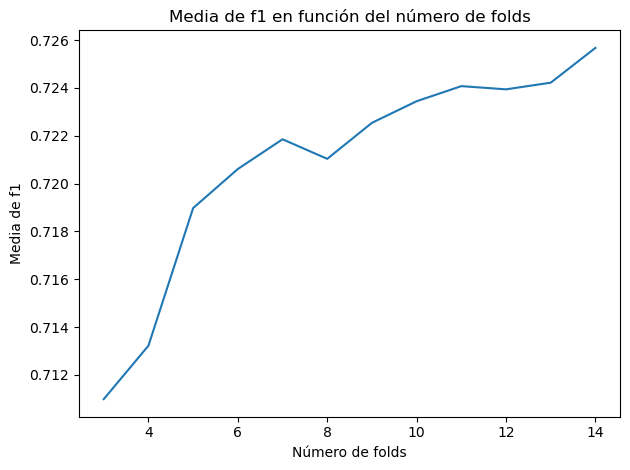

In [32]:
sns.lineplot(x=cantidad_de_folds, y=metricas)
plt.xlabel("Número de folds")
plt.ylabel("Media de f1")
plt.title("Media de f1 en función del número de folds")
plt.tight_layout()
plt.show()

In [33]:
mejor_score_folds = max(metricas)
indice_mejor_cantidad_folds = metricas.index(mejor_score_folds)
print(f"La media maxima es con {indice_mejor_cantidad_folds + 3} folds y su score es de {mejor_score_folds}")

La media maxima es con 14 folds y su score es de 0.7256763200025749


Podemos utilizar esta información para ajustar mejor nuestra búsqueda de hiperparámetros. Si bien 14 folds es el que mejor se ajusta, vamos a probar la búsqueda de hiperparámetros con 7 folds nada mas, ya que, con una cantidad elevada de folds nuestro algoritmo de búsqueda es muy lento.


In [34]:
grilla_parametros = {'n_neighbors': range(3, 15),
                     'weights': ['distance', 'uniform'],
                     'algorithm': ['ball_tree', 'kd_tree'],
                     'metric': ['euclidean', 'manhattan', 'chebyshev']
                     }

iteraciones = 50

knn_hiperparams = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                        param_distributions=grilla_parametros,
                                        scoring=make_scorer(f1_score),
                                        cv=StratifiedKFold(n_splits=7),
                                        n_iter=iteraciones, n_jobs=-1, random_state=33)
                                        

knn_hiperparams.fit(x_train.values, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(3, 15),
                                        'weights': ['distance', 'uniform']},
                   random_state=33, scoring=make_scorer(f1_score))

In [35]:
print(knn_hiperparams.cv_results_['mean_test_score'])
print(knn_hiperparams.best_params_)
print(knn_hiperparams.best_score_)

[0.7053215  0.70562969 0.73502007 0.73344135 0.74844525 0.69078775
 0.7722668  0.74015324 0.78307054 0.75708004 0.73311991 0.73503475
 0.74671296 0.74692115 0.77418703 0.73198404 0.73272881 0.71585673
 0.69881298 0.74665844 0.73727813 0.68749522 0.67185978 0.73447681
 0.7373212  0.78376614 0.73350271 0.77967458 0.67236064 0.69437153
 0.73061596 0.78217357 0.68387775 0.69056381 0.78098771 0.73196726
 0.74809148 0.68658411 0.74836694 0.74964886 0.72992127 0.69489215
 0.67445813 0.73933242 0.69871316 0.73416048 0.75659299 0.72150453
 0.75018704 0.73953113]
{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.783766144805888


Con esto podemos observar los mejores hiperparametros que encontró la búsqueda. Ahora vamos a predictear usando nuestro modelo con estos hiperparametros y ver que resultados obtenemos.

In [36]:
y_pred = knn_hiperparams.predict(x_test.values)

In [37]:
mostrar_scores(y_test, y_pred)

Accuracy: 0.770230607966457
Recall: 0.8141110976642866
Precision: 0.745208817990473
f1 score: 0.7781376518218623


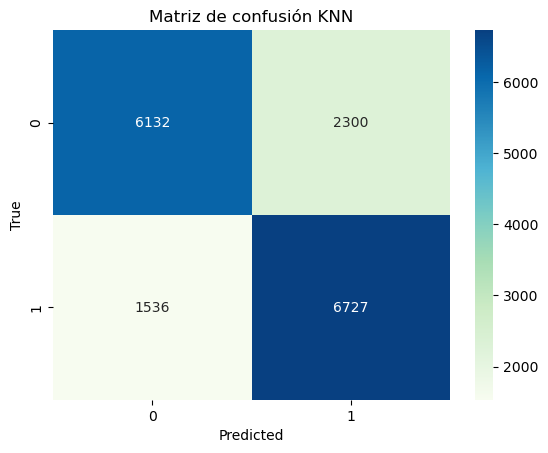

In [38]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como podemos observar, los hiperparametros mejoraron considerablemente el f1 score, sin embargo no es un valor muy alto. Vamos a probar con otros modelos para ver si podemos mejorar este valor.

A continuacion, vamos a ver como se comporta nuestro modelo con los datos de train para analizar si hubo overfitting o no.


In [39]:
y_predict_train = knn_hiperparams.predict(x_train.values)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9963547683224233
Recall: 0.9944502074688797
Precision: 0.9981778425655977
f1 score: 0.9963105383496155


Claramente hubo overfitting, debido a que la cantidad de vecinos más cercanos es muy baja, y por lo tanto, el modelo se ajusta muy bien a los datos de entrenamiento. Podria argumentarse que es por un valor de k muy bajo, sin embargo según investigaciones nuestras, un buen valor de k sería la raíz cuadrada del total de samples que tiene nuestro dataset dividido dos. Además, cabe recalcar que tanto la cantidad de clases como la cantidad de caracteristicas de nuestro dataset no deberían tener un rol importante a la hora de determinar nuestro k.


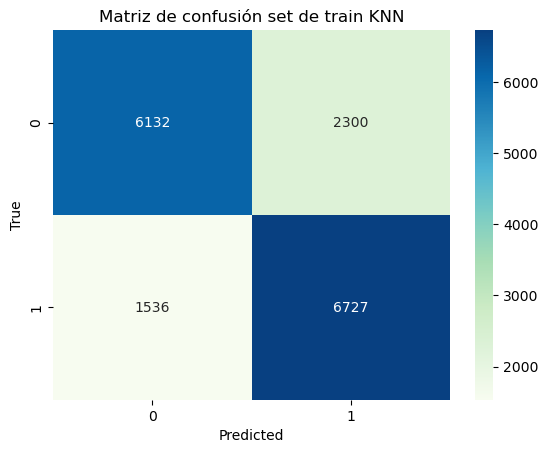

In [40]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión set de train KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ahora vamos a porbar con una cantidad de vecinos mas elevada

In [70]:
cantidad = df_ensambles.shape[0]
vecinos = int(np.sqrt(cantidad))//2

knn_vecinos_alta = KNeighborsClassifier(n_neighbors=vecinos, weights='distance', algorithm='kd_tree', metric='manhattan')

knn_vecinos_alta.fit(x_train.values, y_train)
y_pred = knn_hiperparams.predict(x_test.values)
mostrar_scores(y_test, y_pred)

Accuracy: 0.7702605570530099
Recall: 0.814122345253222
Precision: 0.7452642073778664
f1 score: 0.7781729851652641


In [65]:
y_predict_train = knn_vecinos_alta.predict(x_train.values)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9961590296495957
Recall: 0.9951892529726786
Precision: 0.9970445141635975
f1 score: 0.9961160197151748


Podemos observar que esto tampoco logro reducir el overfit.

### SVM


Para continuar, vamos a crear un modelo de support vector machine para ver que tan bien puede predecir nuestra variable target.


In [41]:
df_a_utilizar = df_ensambles.copy()

In [42]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']),'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']),'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [43]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

df_con_dummies = pd.get_dummies(
    filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.2,
                                                    random_state=11457,
                                                    stratify=df_con_dummies['is_canceled'].values
                                                    )

In [44]:
svm = SVC()

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
mostrar_scores(y_pred, y_test)

Accuracy: 0.610512129380054
Recall: 0.6333484779645616
Precision: 0.5060809584316572
f1 score: 0.562607204116638


Como podemos ver el f1 score es muy bajo, esto puede ser debido a que as variables no estan normalizadas, vamos a intentar con un min-max sclaer y con una normalizacion gaussiana para ver cual obtiene mejores resultados

In [45]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

normal = preprocessing.StandardScaler()
x_train_normal = normal.fit_transform(x_train)
x_test_normal = normal.transform(x_test)

In [46]:
svm_minmax = SVC(random_state=33)

svm_minmax.fit(x_train_minmax, y_train)

y_pred = svm_minmax.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8504941599281222
Recall: 0.833709425446971
Precision: 0.8718460700671629
f1 score: 0.8523513753327419


Al usar una normalizacion por minimos y maximos el f1 score mejoro considerablemente, a continuacion vamos a probar con una normalizacion mediante una distribucion normal

In [47]:
svm_normal = SVC(random_state=33)

svm_normal.fit(x_train_normal, y_train)

y_pred = svm_normal.predict(x_test_normal)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8347708894878706
Recall: 0.8243195475433015
Precision: 0.8466146306044654
f1 score: 0.8353183487060087


Como podemos ver, la normalizacion por minimos y maximos fue considerablemente mejor, es por eso que nos vamos a quedar con el escalado de los datos mediante minimos y maximos.

Ahora vamos a intentar variar el kernel y parametros para ver si podemos mejorar el scoring.

##### Kernel Polinomial

In [48]:
svm_poly = SVC(kernel='poly', random_state=33)

svm_poly.fit(x_train_minmax, y_train)

y_pred = svm_poly.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8499550763701708
Recall: 0.8337680403408103
Precision: 0.8703939008894537
f1 score: 0.8516873889875667


In [49]:
svm_poly_cuadratica = SVC(kernel='poly', degree=2, random_state=33)

svm_poly_cuadratica.fit(x_train_minmax, y_train)

y_pred = svm_poly_cuadratica.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8438454627133872
Recall: 0.8268330733229329
Precision: 0.8658558722091123
f1 score: 0.8458946621741444


In [50]:
svm_poly_5 = SVC(kernel='poly', degree=5, random_state=33)

svm_poly_5.fit(x_train_minmax, y_train)

y_pred = svm_poly_5.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8532794249775382
Recall: 0.8366921473245309
Precision: 0.8742058449809402
f1 score: 0.8550377274744784


Como este fue nuestro mejor modelo SVM vamos a analizarlo un poco mas a detalle.

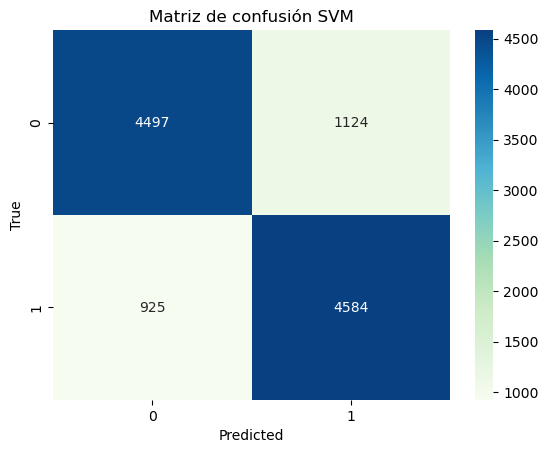

In [61]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Luego veremos como se comporta nuestro modelo con el dataset que entrenó para ver si hubo underfitting u overfitting.

In [62]:
y_pred_train = svm_poly_5.predict(x_train_minmax)
mostrar_scores(y_pred_train, y_train)

Accuracy: 0.869362084456424
Recall: 0.8546003148504461
Precision: 0.8869474448579469
f1 score: 0.8704734755690171


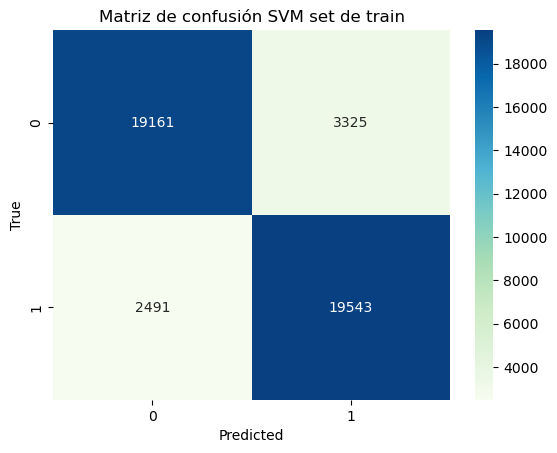

In [63]:
tabla = confusion_matrix(y_train, y_pred_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión SVM set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [51]:
svm_poly_5_gamma = SVC(kernel='poly', degree=5, gamma='auto', random_state=33)

svm_poly_5_gamma.fit(x_train_minmax, y_train)

y_pred = svm_poly_5_gamma.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.5050314465408805
Recall: 0.0
Precision: 0.0
f1 score: 0.0


c:\Users\mateo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Kernel Sigmoide

In [58]:
svm_sigmoide = SVC(kernel='sigmoid')

svm_sigmoide.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.6393530997304582
Recall: 0.6341288354566661
Precision: 0.6414957342530405
f1 score: 0.6377910124526259


In [59]:
svm_sigmoide_gamma = SVC(kernel='sigmoid', gamma='auto')

svm_sigmoide_gamma.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide_gamma.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8159029649595687
Recall: 0.803083391730904
Precision: 0.8320929388273733
f1 score: 0.8173308371222252


##### Kernel Lineal

In [71]:
svm_lin = SVC(kernel='linear', random_state=33)

svm_lin.fit(x_train_minmax, y_train)
y_pred = svm_lin.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8252470799640611
Recall: 0.8127413127413128
Precision: 0.840624432746415
f1 score: 0.8264477558668689


Como podemos ver, luego de intentar varios kernels con varios parametros diferentes, el modelo que mejor resulto para predecir nuestra variable target fue el kernel polinomial con grado 5. Por lo tanto vamos a utilizar ese modelo para los ensambles hibridos mas tarde.

### RandomForest


In [72]:
df_a_utilizar = df_ensambles.copy()

#### RandomForest Basico


Utilizamos todas las features del dataset para entrenar el modelo. Luego, vamos a ir variando las features para ver si mejora o empeora nuestro clasificador.


In [73]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'month',
    'week_number',
    'day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'meal_type',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'reserved_room_type',
    'assigned_room_type',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_nights',
    'total_people'
]

filtrado = df_a_utilizar[columns]

dummy_columns = ['hotel', 'deposit_type', 'market_segment', 'agent_id', 'country', 'customer_type',
                 'meal_type', 'reserved_room_type', 'assigned_room_type', 'distribution_channel', 'month', 'year']
df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Primero, vamos a probar con un random forest con pocos parametros. Luego, vamos a realizar una busqueda de hiperparametros para ver si podemos mejorar el modelo.


In [74]:
random_forest_basico = RandomForestClassifier(max_depth=20, random_state=33, n_estimators=50, n_jobs=-1)
random_forest_basico.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 33,
 'verbose': 0,
 'warm_start': False}

In [75]:
modelo = random_forest_basico.fit(X=x_train, y=y_train)
y_pred = modelo.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8642707397424378
Recall: 0.8530799951591431
Precision: 0.8701394889519812
f1 score: 0.8615252994377902


Ya de por si el random forest nos dio un resultado relativamente alto comparado a los otros modelos de ensambles, vamos a ver si podemos mejorar este puntaje con hiperparametros y seleccionando variables

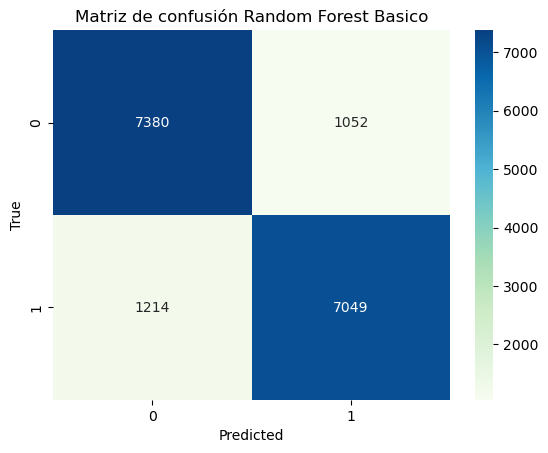

In [76]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Basico')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [77]:
y_predict_train = modelo.predict(x_train)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9182389937106918
Recall: 0.9223029045643154
Precision: 0.9133494272946736
f1 score: 0.9178043304343338


Hay un leve overfit pero esto no deberia preocuparnos en este momento, ya que este es el modelo de RandomForest mas basico que vamos a utilizar. A continuacion vamos a probar con un modelo mas complejo para ver si podemos mejorar el puntaje.

#### RandomForest Mejorado


Vamos a filtrar variables de manera que nuestro modelo de ensamble RandomForest mejore su predicción.

In [78]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

Vamos a realizar un filtrado tal como hicimos antes con los arboles de decisión ya que, como las variables agent_id y country pueden tomar demasiados valores distintos, existe la posibilidad de que el modelo tenga un nodo de decision con un valor que no existe en el dataset de test o viceversa.


In [79]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [80]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [81]:
random_forest_mejorado = RandomForestClassifier(criterion='entropy',
                                                max_depth=25,
                                                min_samples_leaf=1,
                                                n_estimators=100,
                                                random_state=13,
                                                n_jobs=-1,
                                                max_features='sqrt',
                                                class_weight='balanced_subsample',
                                                )
random_forest_mejorado.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

Usamos un escalador ya que no afecta nuestro árbol, pero si afecta a los ensambles híbridos que vamos a realizar más adelante. Esto se debe a que los ensambles híbridos utilizan el support vector machine como clasificador, y este necesita que los datos esten escalados para poder funcionar correctamente.

In [82]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


modelo = random_forest_mejorado.fit(X=x_train_minmax, y=y_train)
y_pred = modelo.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8756513926325247
Recall: 0.8830933075154302
Precision: 0.8679671702152968
f1 score: 0.8754649070185964


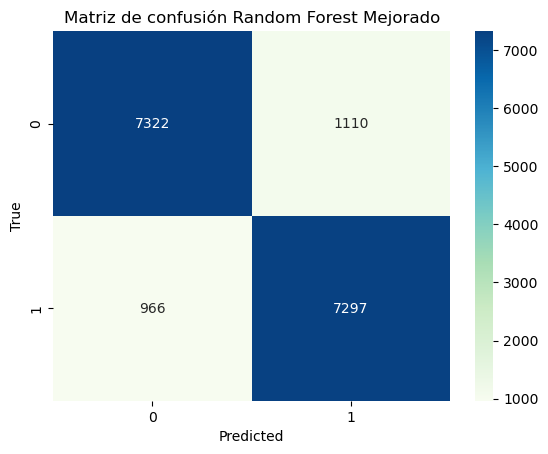

In [83]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Mejorado')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [84]:
y_predict_train = modelo.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9399820305480683
Recall: 0.9607883817427386
Precision: 0.9213170197950861
f1 score: 0.9406388056669882


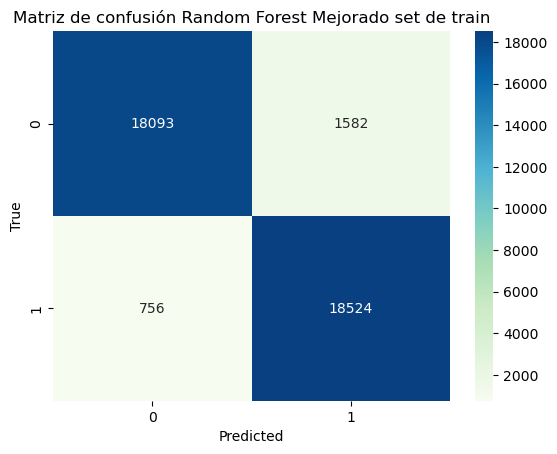

In [85]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Mejorado set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Es normal que un random forest se overfitee un poco, por lo tanto, no nos deberia alarmar esta metrica. Es por esto que por ejemplo no utilicemos poda, para que nuestro arbol se extienda lo maximo posible. Ademas, el bootstraping y el bagging tambien ayudan a que el overfit no genere problemas ya que por cada arbol se toman distintos samples de datos.


Para la busqueda de hiperparametros vamos a dejar un numero de iteraciones bajo, pero anteriormente ya habiamos probado con un numero de iteraciones mas alto y guardamos los resultados. Por lo tanto, vamos a dejarlo en 10 para que la busqueda sea mas rapida.

In [88]:
from sklearn.model_selection import RandomizedSearchCV

randomforest_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)
iteraciones = 25

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_randomCV = RandomizedSearchCV(estimator=randomforest_cv, param_distributions=param_grid, cv=6, verbose=2, n_jobs=-1, random_state=33, n_iter=iteraciones)
rf_randomCV.fit(x_train, y_train)
rf_randomCV.best_params_


Fitting 6 folds for each of 25 candidates, totalling 150 fits


{'n_estimators': 100,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'class_weight': 'balanced_subsample'}

In [89]:
modelo = rf_randomCV.best_estimator_
y_pred = modelo.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8744534291704104
Recall: 0.8838194360401791
Precision: 0.8653868941817751
f1 score: 0.8745060471799784


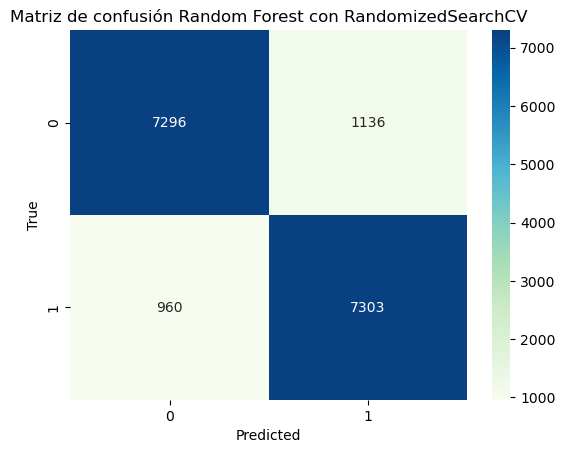

In [90]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest con RandomizedSearchCV')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [91]:
y_predict_train = modelo.predict(x_train)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9514311384931331
Recall: 0.9728215767634855
Precision: 0.9320214669051878
f1 score: 0.9519845700944067


Con esto buscamos los mejores hiperparametros para nuestro random forest. Evitamos que los arboles se poden ya que esto no es beneficioso para los mismos.

## XGBoost

In [ ]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

Utilizamos este rango de columnas para ir filtrando con el objetivo de que nuestro modelo mejore.

In [ ]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Realizamos el mismo filtrados que en el random forest ya uqe notamos uqe con los arboles de decision nos dieron muy buenos resultados.

In [ ]:
target = 'is_canceled'
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [ ]:
import xgboost as xgb

dtrain_clf = xgb.DMatrix(x_train, y_train)
dtest_clf = xgb.DMatrix(x_test, y_test)

Accuracy: 0.8740341419586702
Recall: 0.8882972286094639
Precision: 0.8615023474178404
f1 score: 0.8746946314723231


In [ ]:
iteraciones = 25
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 25, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [0, 1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0.1, 0.2, 0.3, 0.4]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

xgb_randomCV = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, cv=5, n_jobs=-1, random_state=33, n_iter=iteraciones)
xgb_randomCV.fit(x_train, y_train)
xgb_randomCV.best_params_

Utilizamos un poco menos de folds porque esta busqueda de hiperparametros es muy costosa.

In [ ]:
y_pred = xgb_randomCV.predict(x_test)
mostrar_scores(y_test, y_pred)

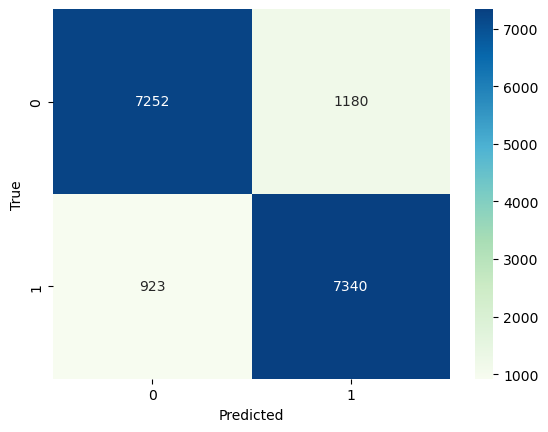

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Vemos como se comporta con los datos de entrenamiento.

In [ ]:
y_pred_train = xgb_randomCV.predict(x_train)
mostrar_scores(y_train, y_pred_train)

In [ ]:
tabla = confusion_matrix(y_train, y_pred_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

A continuacion probamos otro modelo de XGBoost pero con muchos estimadores para ver como se comporta. Creemos que este modelo va a tener un overfitting muy grande, pero vamos a probarlo igual para ver que resultados obtenemos.

In [ ]:
import xgboost as xgb

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


xgb_model = xgb.XGBClassifier(n_estimators=1000, eta=0.04,
                              max_depth=8, min_child_weight=1, colsample_bytree=0.8,  seed=27)
xgb_model.fit(x_train_minmax, y_train)
y_pred = xgb_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8786463012878107
Recall: 0.8925329783371657
Precision: 0.8663220956184658
f1 score: 0.8792322365283739


In [ ]:
y_predict_train = modelo.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9543575920934412
Recall: 0.9804979253112033
Precision: 0.9309563675760859
f1 score: 0.9550851311069571


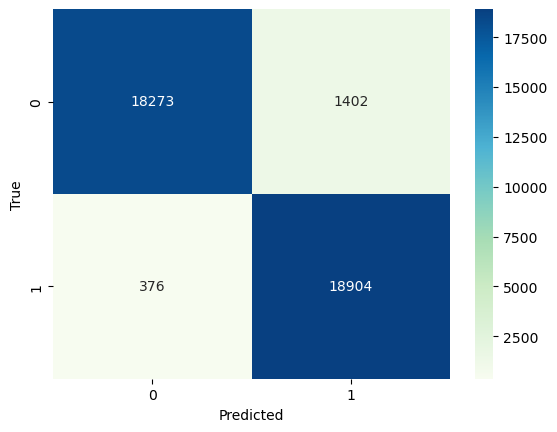

In [ ]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como se puede observar este modelo tambien esta levemente sobreentrenado. Sin embargo, en el submit de kaggle dió bastante alto, pero, quizas cuando se vean los resultados de la tabla privada ahi se puede notar el problema del overfit, ya que en ese caso se predice un volumen más alto de datos.

## Stacking


Ahora vamos a probar los ensambles hibridos con nuestros modelos previamente entrenados. Vamos a quedarnos con los mejores modelos de cada tipo de ensamble para ver que resultados obtenemos.

In [ ]:
df_a_utilizar = df_ensambles.copy()

In [ ]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [ ]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)


df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Al final, el ensamble híbrido nos da mejores resultados sin el SVM, pero de todas maneras conservamos el escalador ya que no afecta a los árboles de decisión, pero ya fueron entrenados con el escalador.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  ("xg boost", xgb_model),
]

log_model = LogisticRegression(random_state=33, max_iter=1000, n_jobs=-1, penalty='l2', C=0.1)

stacking_model = StackingClassifier(estimators=estimadores,
                                    passthrough=True,
                                    final_estimator=log_model,
                                    cv='prefit',
                                    verbose=2, 
                                    
                                    n_jobs=-1)

stacking_model.fit(x_train_minmax, y_train)
y_pred = stacking_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.879005690326445
Recall: 0.878494493525354
Precision: 0.8772205438066465
f1 score: 0.8778570564759947


In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Stacking')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Luego veremos como se comporta con los datos de entrenamiento.

In [ ]:
y_predict_train = stacking_model.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9616480554485946
Recall: 0.9696576763485477
Precision: 0.9536319118547235
f1 score: 0.9615780269519597


In [ ]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Stacking set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Podemos ver que presenta un leve overfit, pero es esperable ya que los estimadores usados también presentaban un pequeño overfit.

## Voting

In [ ]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

In [ ]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [ ]:
from sklearn.ensemble import VotingClassifier

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  ("xg boost", xgb_model)
]

voting_model = VotingClassifier(estimators=estimadores,
                                    verbose=2, 
                                    n_jobs=-1)

voting_model.fit(x_train, y_train)
y_pred = voting_model.predict(x_test)
mostrar_scores(y_test, y_pred)

[Voting] ............ (1 of 2) Processing random forest, total=   9.1s
[Voting] ................. (2 of 2) Processing xg boost, total= 4.2min
Accuracy: 0.873015873015873
Recall: 0.8581628948323853
Precision: 0.8820748849359373
f1 score: 0.8699546067967121


In [ ]:
#heatmap voting 
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Voting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Evaluación con el dataset de test

In [ ]:
df_test = pd.read_csv('https://drive.usercontent.google.com/download?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download&authuser=0&confirm=t&uuid=2892328a-d7d8-47c7-98e1-3e69ef723100&at=APZUnTU5aCf9tHsTaF3PM7aD9Lym:1695760323667')

df_test.shape

(26535, 31)

### Imputacion

In [ ]:
nuevas_columnas = {
    'arrival_date_year' : 'year',
    'arrival_date_month' : 'month',
    'arrival_date_week_number' : 'week_number',
    'arrival_date_day_of_month' : 'day_of_month',
    'meal' : 'meal_type',
    'agent' : 'agent_id',
    'adr' : 'average_daily_rate'
}
df_test.rename(columns = nuevas_columnas, inplace = True)

Imputacion children, company y adults

In [ ]:
df_test['total_nights'] = df_test['stays_in_week_nights'] + df_test['stays_in_weekend_nights']
df_test['children'].fillna(0, inplace=True)
df_test['total_people'] = df_test['adults'] + df_test['children'] + df_test['babies']
df_test['meal_type'].replace(['SC', 'Undefined'], 'NoMeal', inplace=True)
df_test.drop(columns=['company'], inplace=True)

Imputación de agent id

In [ ]:
for index, row in df_test.iterrows():
    if (pd.isna(row['agent_id'])) & (row['distribution_channel'] == 'Direct'):
        df_test.loc[index, 'agent_id'] = -1

for index, row in df_test.iterrows():
    if (not pd.isna(row['agent_id'])) or (row['distribution_channel'] == 'Direct'):
        continue
    if row['hotel'] == 'City Hotel':
        if row['country'] == 'PRT':
            df_test.loc[index, 'agent_id'] = 1.0
        else: 
            df_test.loc[index, 'agent_id'] = 9.0
    else:
        df_test.loc[index, 'agent_id'] = 240.0

Imputación de country

In [ ]:
for index, row in df_test.iterrows():
    if pd.isna(row['country']) and row['deposit_type'] == 'Non Refund':
        df_test.loc[index, 'country'] = 'PRT'

for index, row in df_test.iterrows():
    if pd.isna(row['country']) and (row['market_segment'] == 'Corporate' or row['market_segment'] == 'Offline TA/TO' or row['market_segment'] == 'Direct'):
        df_test.loc[index, 'country'] = 'PRT'

In [ ]:
mejor_modelo = stacking_model

In [ ]:
df_encode = df_test.copy()

df_encode['agent_id'] = df_test['agent_id'].apply(lambda x: x if x in list(df_agentes_mayoritarios['agent_id']) else 'Otros')
df_encode['country'] = df_test['country'].apply(lambda x: x if x in list(df_paises_mayoritarios['country']) else 'Otros')

columns.remove('is_canceled')
df_filtrado = df_encode[columns]
columns.append('is_canceled')
df_test_con_dummies = pd.get_dummies(df_filtrado, columns=dummy_columns, drop_first=True).reset_index(drop=True)

df_test_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_test_con_dummies['cuarto_correcto'] = df_test_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_minmax = min_max.transform(df_test_con_dummies)

y_pred = mejor_modelo.predict(df_minmax)

df_prediccion = pd.DataFrame(y_pred, columns=['is_canceled'])
df_prediccion['id'] = df_test['id']
df_prediccion = df_prediccion[['id', 'is_canceled']]


df_prediccion.to_csv('prediccion.csv', index=False)